In [60]:
import pandas as pd
import numpy as np
import datetime as dt
import pickle
from io import StringIO
from sklearn.tree import export_graphviz
import pydotplus
from PIL import Image
import seaborn as sns

import patsy
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import normalize
from sklearn.utils import resample
from sklearn.model_selection import ShuffleSplit


from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

In [2]:
pd.set_option('display.max_colwidth', -1)

In [3]:
!ls -l

total 1174640
-rw-rw-r-- 1 brendanfitzpatrick brendanfitzpatrick     22092 Aug  2 09:37 03-mcnulty_brendan_choropleths.ipynb
-rw-r--r-- 1 brendanfitzpatrick brendanfitzpatrick    122047 Aug  2 09:56 03_mcnulty_brendan_cleaning.ipynb
-rw-rw-r-- 1 brendanfitzpatrick brendanfitzpatrick      8344 Aug  2 12:23 03-mcnulty_brendan_donuts.ipynb
-rw-rw-r-- 1 brendanfitzpatrick brendanfitzpatrick      6552 Aug  1 22:00 03-mcnulty_brendan_flask_model.ipynb
-rw-rw-r-- 1 brendanfitzpatrick brendanfitzpatrick     78461 Jul 30 03:41 03_mcnulty_brendan_modeling-Copy1.ipynb
-rw-rw-r-- 1 brendanfitzpatrick brendanfitzpatrick     65356 Aug  2 13:27 03_mcnulty_brendan_modeling.ipynb
-rwxr-xr-x 1 brendanfitzpatrick brendanfitzpatrick    172221 Jul 28 21:30 challenge_set_1_brendan.ipynb
-rw-r--r-- 1 brendanfitzpatrick brendanfitzpatrick    178337 Jul 28 15:12 challenge_set_7_brendan.ipynb
-rw-rw-r-- 1 brendanfitzpatrick brendanfitzpatrick     28379 Jul 28 20:40 challenge_set_8_brendan.ipynb
-rw-rw-r-- 1 bre

In [4]:
with open("df_inv.pkl", 'rb') as picklefile: 
    df = pickle.load(picklefile)

In [5]:
df_key = pd.read_excel('LCDataDictionary.xlsx')
df_key.set_index('LoanStatNew')

,Description
LoanStatNew,
addr_state,The state provided by the borrower in the loan application
annual_inc,The self-reported annual income provided by the borrower during registration.
annual_inc_joint,The combined self-reported annual income provided by the co-borrowers during registration
application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers
collection_recovery_fee,post charge off collection fee
collections_12_mths_ex_med,Number of collections in 12 months excluding medical collections
delinq_2yrs,The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
desc,Loan description provided by the borrower
dti,"A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income."


&nbsp;
### Make Feature and Targets (1=Default, 0=Paid)
&nbsp;

In [6]:
df['loan_status_indicator'] = df.loan_status.apply(lambda x: 1 if x == 'Default' else 0)

In [7]:
feature_list = ['loan_amnt',
                'lc_allocation',
                'term',
                'int_rate',
                'installment',
                'emp_length_greater_1_yr',
                'emp_length_greater_5_yrs',
                'emp_length_greater_10_yrs',
                'home_ownership_intercept',
                'home_ownership_mortgage',
                'home_ownership_none',
                'home_ownership_other',
                'home_ownership_own',
                'home_ownership_rent',
                'annual_inc',
                'verification_intercept',
                'source_verified',
                'verified',
                'pymnt_plan',
                'dti',
                'delinq_2yrs',
                'earliest_cr_line_delta',
                'inq_last_6mths',
                'record_within_1',
                'record_within_2',
                'record_within_5',
                'open_acc',
                'pub_rec',
                'revol_bal',
                'revol_util',
                'total_acc',
                'initial_list_status',
                'out_prncp',
                'major_derog_within_1',
                'major_derog_within_2',
                'major_derog_within_5',]

In [8]:
X = df[feature_list]
y = df.loan_status.values.ravel()

In [9]:
df.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,annual_inc,pymnt_plan,...,home_ownership_intercept,home_ownership_mortgage,home_ownership_none,home_ownership_other,home_ownership_own,home_ownership_rent,verification_intercept,source_verified,verified,loan_status_indicator
count,2.539890e+05,2.539890e+05,253989.000000,253989.000000,253989.000000,253989.000000,253989.000000,253989.000000,2.539890e+05,253989.000000,...,253989.0,253989.000000,253989.000000,253989.000000,253989.000000,253989.000000,253989.0,253989.000000,253989.000000,253989.00000
mean,1.234216e+07,1.366335e+07,13573.199036,13532.786558,13440.318120,41.365272,13.774226,418.344964,7.250452e+04,0.000008,...,1.0,0.493143,0.000169,0.000547,0.086909,0.419227,1.0,0.292981,0.367335,0.18276
std,1.479763e+07,1.576526e+07,8132.172366,8109.798208,8128.158126,9.999039,4.404041,244.870325,5.876336e+04,0.002806,...,0.0,0.499954,0.013010,0.023387,0.281703,0.493434,0.0,0.455131,0.482080,0.38647
min,5.473400e+04,7.069900e+04,500.000000,500.000000,0.000000,36.000000,5.320000,15.690000,3.000000e+03,0.000000,...,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.00000
25%,1.462762e+06,1.710148e+06,7275.000000,7200.000000,7200.000000,36.000000,10.740000,239.780000,4.500000e+04,0.000000,...,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.00000
50%,6.324748e+06,7.661224e+06,12000.000000,12000.000000,11975.000000,36.000000,13.530000,365.230000,6.200000e+04,0.000000,...,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.00000
75%,1.655239e+07,1.858546e+07,18250.000000,18150.000000,18000.000000,36.000000,16.550000,547.580000,8.700000e+04,0.000000,...,1.0,1.000000,0.000000,0.000000,0.000000,1.000000,1.0,1.000000,1.000000,0.00000
max,6.860466e+07,7.350742e+07,35000.000000,35000.000000,35000.000000,60.000000,28.990000,1424.570000,8.706582e+06,1.000000,...,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.00000


In [10]:
models = [LogisticRegression(n_jobs=-1),
          GaussianNB(),
          DecisionTreeClassifier(),
          RandomForestClassifier(n_jobs=-1),
          KNeighborsClassifier(n_neighbors=4,n_jobs=-1)]
model_names = ['Logistic', 'Naive Bayes','Decision Tree', 'Random Forest','KNN']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=1234)

accuracy = []
precision_default = []
precision_fully_paid = []
recall_default = []
recall_fully_paid = []
f1_default = []
f1_fully_paid = []
confusion_matrices = []

for model in models:
    model.fit(X_train,y_train)
    y_hat = model.predict(X_test)
    
    accuracy.append(accuracy_score(y_test, y_hat))
    precision_default.append(precision_score(y_test, y_hat, pos_label='Default'))
    precision_fully_paid.append(precision_score(y_test, y_hat, pos_label='Fully Paid') )
    recall_default.append(recall_score(y_test, y_hat, pos_label='Default'))
    recall_fully_paid.append(recall_score(y_test, y_hat, pos_label='Fully Paid'))
    f1_default.append(f1_score(y_test, y_hat, pos_label='Default'))
    f1_fully_paid.append(f1_score(y_test, y_hat, pos_label='Fully Paid'))
    confusion_matrices.append(confusion_matrix(y_test,y_hat))

In [12]:
accuracy_df = pd.DataFrame({'accuracy':accuracy, 
                            'precision_default':precision_default, 
                            'precision_fully_paid':precision_fully_paid,
                            'recall_default':recall_default, 
                            'recall_fully_paid':recall_fully_paid, 
                            'f1_default':f1_default, 
                            'f1_fully_paid':f1_fully_paid})
accuracy_df.set_index([model_names])

,accuracy,f1_default,f1_fully_paid,precision_default,precision_fully_paid,recall_default,recall_fully_paid
Logistic,0.821410,0.052368,0.901416,0.954315,0.820719,0.026923,0.999711
Naive Bayes,0.818156,0.066056,0.899272,0.563218,0.821100,0.035085,0.993894
Decision Tree,0.722207,0.277009,0.828074,0.264842,0.837220,0.290348,0.819126
Random Forest,0.797459,0.237010,0.883231,0.382846,0.834577,0.171631,0.937909
KNN,0.732457,0.220361,0.838522,0.236496,0.826837,0.206287,0.850541


In [13]:
print('Matrix Key\n[[True Negative\t\tFalse Positive]\n'+
      '[False Negative\t\tTrue Positive]]\n')

for i in range(4):
    print('Confusion Matrix: '+model_names[i])
    print(confusion_matrices[i])
    print(confusion_matrices[i]/confusion_matrices[i].sum(),'\n')

Matrix Key
[[True Negative		False Positive]
[False Negative		True Positive]]

Confusion Matrix: Logistic
[[  376 13590]
 [   18 62213]]
[[  4.93457748e-03   1.78353478e-01]
 [  2.36229773e-04   8.16475714e-01]] 

Confusion Matrix: Naive Bayes
[[  490 13476]
 [  380 61851]]
[[ 0.0064307   0.17685736]
 [ 0.00498707  0.81172487]] 

Confusion Matrix: Decision Tree
[[ 4055  9911]
 [11256 50975]]
[[ 0.05321732  0.13007074]
 [ 0.14772235  0.66898959]] 

Confusion Matrix: Random Forest
[[ 2397 11569]
 [ 3864 58367]]
[[ 0.03145793  0.15183012]
 [ 0.05071066  0.76600129]] 



#### Make Random Index using ShuffleSplit

In [14]:
rs = ShuffleSplit(n_splits=1,test_size=0.3,random_state=1234)
ind = rs.split(df)

In [15]:
for train,test in rs.split(df):
    train_index, test_index = train, test

In [16]:
#### Add back in loan status indicator to feature list

#### Normalize Samples

In [17]:
resample_features = list(feature_list)
resample_features.append('loan_status_indicator')

In [18]:
X_norm = df[resample_features]
X_norm_columns = X_norm.columns
X_norm = normalize(df[resample_features], axis=0, norm='max')
X_norm = pd.DataFrame(X_norm)
X_norm.columns = X_norm_columns

#### Train-Test Split

In [19]:
X_norm_train = X_norm.iloc[train_index,:]
X_norm_test = X_norm.iloc[test_index,:].drop('loan_status_indicator',1)
y_train = X_norm.loan_status_indicator.iloc[train_index]
y_test = X_norm.loan_status_indicator.iloc[test_index]

#### Add back in 'Loan Status Indicator' to feature matrix

In [20]:
sample_size = X_norm_train[X_norm_train.loan_status_indicator==0].shape[0]
print(sample_size)

145339


In [21]:
df_majority = X_norm_train[X_norm_train.loan_status_indicator==0]
df_minority = X_norm_train[X_norm_train.loan_status_indicator==1]
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     
                                 n_samples=sample_size,   # the number of the majority from the above value counts 
                                 random_state=1234)
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

In [22]:
df_upsampled.loan_status_indicator.value_counts()

1.0    145339
0.0    145339
Name: loan_status_indicator, dtype: int64

In [23]:
y_upsampled = df_upsampled['loan_status_indicator']
X_upsampled = df_upsampled.drop(['loan_status_indicator'], axis=1)

In [24]:
resample_models = [LogisticRegression(n_jobs=-1),
                   GaussianNB(), 
                   DecisionTreeClassifier(),
                   RandomForestClassifier(n_jobs=-1),
                   KNeighborsClassifier(n_neighbors=4,n_jobs=-1)]

In [25]:
rs_accuracy = []
rs_precision_default = []
rs_precision_fully_paid = []
rs_recall_default = []
rs_recall_fully_paid = []
rs_f1_default = []
rs_f1_fully_paid = []
rs_confusion_matrices = []

for model in resample_models:
    model.fit(X_upsampled,y_upsampled)
    y_hat = model.predict(X_norm_test)
    
    rs_accuracy.append(accuracy_score(y_test, y_hat))
    rs_precision_default.append(precision_score(y_test, y_hat, pos_label=1))
    rs_precision_fully_paid.append(precision_score(y_test, y_hat, pos_label=0) )
    rs_recall_default.append(recall_score(y_test, y_hat, pos_label=1))
    rs_recall_fully_paid.append(recall_score(y_test, y_hat, pos_label=0))
    rs_f1_default.append(f1_score(y_test, y_hat, pos_label=1))
    rs_f1_fully_paid.append(f1_score(y_test, y_hat, pos_label=0))
    rs_confusion_matrices.append(confusion_matrix(y_test,y_hat))

In [26]:
rs_accuracy_df = pd.DataFrame({'accuracy':rs_accuracy, 
                            'precision_default':rs_precision_default, 
                            'precision_fully_paid':rs_precision_fully_paid,
                            'recall_default':rs_recall_default, 
                            'recall_fully_paid':rs_recall_fully_paid, 
                            'f1_default':rs_f1_default, 
                            'f1_fully_paid':rs_f1_fully_paid})
rs_accuracy_df.set_index([model_names])

,accuracy,f1_default,f1_fully_paid,precision_default,precision_fully_paid,recall_default,recall_fully_paid
Logistic,0.659868,0.405969,0.761716,0.298554,0.890188,0.634111,0.665649
Naive Bayes,0.799402,0.167348,0.885964,0.349806,0.826895,0.109981,0.954123
Decision Tree,0.730002,0.265014,0.834626,0.264456,0.835022,0.265574,0.834231
Random Forest,0.804152,0.213295,0.888154,0.404357,0.832247,0.144852,0.952114
KNN,0.677323,0.296489,0.790651,0.246914,0.840892,0.370972,0.746075


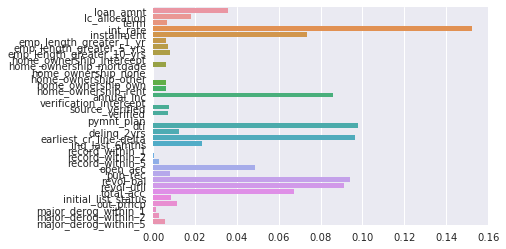

In [67]:
sns.barplot(x=resample_models[2].feature_importances_,y=X_upsampled.columns);

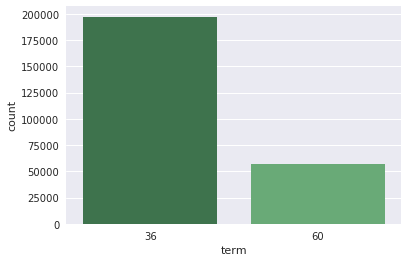

In [99]:
sns.countplot(x="term", data=df, palette="Greens_d");

In [27]:
print('Matrix Key\n[[True Negative\t\tFalse Positive]\n'+
      '[False Negative\t\tTrue Positive]]\n')

for i in range(4):
    print('Confusion Matrix: '+model_names[i])
    print(rs_confusion_matrices[i])
    print(rs_confusion_matrices[i]/rs_confusion_matrices[i].sum(),'\n')

Matrix Key
[[True Negative		False Positive]
[False Negative		True Positive]]

Confusion Matrix: Logistic
[[41424 20807]
 [ 5110  8856]]
[[ 0.54364345  0.27306849]
 [ 0.06706301  0.11622505]] 

Confusion Matrix: Naive Bayes
[[59376  2855]
 [12430  1536]]
[[ 0.77924328  0.03746867]
 [ 0.16312978  0.02015827]] 

Confusion Matrix: Decision Tree
[[51915 10316]
 [10257  3709]]
[[ 0.68132604  0.13538591]
 [ 0.1346116   0.04867646]] 

Confusion Matrix: Random Forest
[[59251  2980]
 [11943  2023]]
[[ 0.77760279  0.03910915]
 [ 0.15673845  0.0265496 ]] 



In [41]:
decision_tree = DecisionTreeRegressor(max_depth=4)
decision_tree.fit(X_upsampled,y_upsampled)
print("Decision Tree RMSE:",np.sqrt(
    mean_squared_error(y_test,decision_tree.predict(X_test))))


dot_data = StringIO()  
export_graphviz(decision_tree, out_file=dot_data,  
                    feature_names=X_upsampled.columns.tolist(),  
                    filled=True, rounded=True,  
                    special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

Decision Tree RMSE: 0.602794561667


TypeError: 'module' object is not callable

In [96]:
def p_threshold_plot(model, X, y):
    probs_pred = model.predict_proba(X)[:,1]
    thresh_range = np.linspace(.4, .5, 200)

    f1_scores = []
    for thresh in thresh_range:
        y_pred = [1 if prob >= thresh else 0 for prob in probs_pred]
        f1_scores.append(f1_score(y, y_pred))
    
    return thresh_range, f1_scores

In [97]:
accuracy = []
precision_default = []
precision_fully_paid = []
recall_default = []
recall_fully_paid = []
f1_default = []
f1_fully_paid = []
confusion_matrices = []
counter=0

for model in resample_models:
    model_thresh, model_recalls = p_threshold_plot(model, X_test, y_test)
    model_best_thresh = model_thresh[np.argmax(model_recalls)]
    print(model_names[counter])
    counter+=1

    y_test_probs_pred = model.predict_proba(X_test)[:,1] 
    y_hat = [1 if prob >= model_best_thresh else 0 for prob in y_test_probs_pred]
    accuracy.append(accuracy_score(y_test, y_hat))
    precision_default.append(precision_score(y_test, y_hat, pos_label=1))
    precision_fully_paid.append(precision_score(y_test, y_hat, pos_label=0) )
    recall_default.append(recall_score(y_test, y_hat, pos_label=1))
    recall_fully_paid.append(recall_score(y_test, y_hat, pos_label=0))
    f1_default.append(f1_score(y_test, y_hat, pos_label=1))
    f1_fully_paid.append(f1_score(y_test, y_hat, pos_label=0))
    confusion_matrices.append(confusion_matrix(y_test,y_hat))

/home/brendanfitzpatrick/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:352: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/brendanfitzpatrick/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Logistic


/home/brendanfitzpatrick/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Naive Bayes
Decision Tree
Random Forest
KNN


In [98]:
accuracy_df = pd.DataFrame({'accuracy':accuracy, 
                            'precision_default':precision_default, 
                            'precision_fully_paid':precision_fully_paid,
                            'recall_default':recall_default, 
                            'recall_fully_paid':recall_fully_paid, 
                            'f1_default':f1_default, 
                            'f1_fully_paid':f1_fully_paid})
accuracy_df.set_index([model_names])

,accuracy,f1_default,f1_fully_paid,precision_default,precision_fully_paid,recall_default,recall_fully_paid
Logistic,0.816712,0.000000,0.899110,0.000000,0.816712,0.000000,1.000000
Naive Bayes,0.183393,0.309745,0.000418,0.183266,0.722222,0.999642,0.000209
Decision Tree,0.820898,0.052489,0.901102,0.864989,0.820644,0.027066,0.999052
Random Forest,0.632190,0.221240,0.759239,0.180774,0.815690,0.285049,0.710096
KNN,0.183275,0.309776,0.000000,0.183277,0.000000,0.999928,0.000000


In [73]:
print('Matrix Key\n[[True Negative\t\tFalse Positive]\n'+
      '[False Negative\t\tTrue Positive]]\n')

for i in range(4):
    print('Confusion Matrix: '+model_names[i])
    print(confusion_matrices[i])
    print(confusion_matrices[i]/confusion_matrices[i].sum(),'\n')

Matrix Key
[[True Negative		False Positive]
[False Negative		True Positive]]

Confusion Matrix: Logistic
[[62231     0]
 [13966     0]]
[[ 0.81671194  0.        ]
 [ 0.18328806  0.        ]] 

Confusion Matrix: Naive Bayes
[[   13 62218]
 [    5 13961]]
[[  1.70610391e-04   8.16541334e-01]
 [  6.56193813e-05   1.83222437e-01]] 

Confusion Matrix: Decision Tree
[[62172    59]
 [13588   378]]
[[  8.15937635e-01   7.74308700e-04]
 [  1.78327231e-01   4.96082523e-03]] 

Confusion Matrix: Random Forest
[[ 6185 56046]
 [ 1588 12378]]
[[ 0.08117117  0.73554077]
 [ 0.02084072  0.16244734]] 



In [84]:
with open("ui_data.pkl", 'rb') as picklefile: 
    df = pickle.load(picklefile)
feature_list = ['int_rate', 'dti', 'earliest_cr_line_delta']
X = df[feature_list]
Y = df.loan_status.apply(lambda x: 1 if x == 'Default' else 0).values.ravel()
PREDICTOR = LogisticRegression().fit(X,Y)

In [85]:
PREDICTOR.predict_proba([13,16,168])

/home/brendanfitzpatrick/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([[ 0.85105364,  0.14894636]])

In [ ]:
X.describe()